In [40]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import re
from re import findall as fa
import sqlite3
import pymorphy2


from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier 
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from scipy.stats.stats import pearsonr as corr

from nltk.tokenize import word_tokenize




from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

from keras.layers import Embedding, Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.models import Model, Sequential

import seaborn as sns

import matplotlib.pyplot as plt
from jupyterthemes import jtplot #внешний вид ноутбука и графиков
jtplot.style(theme='onedork')

import random
random.seed(1228)

from sklearn.metrics import precision_score, recall_score, confusion_matrix

%matplotlib inline

In [2]:
text = """
Иногда я пишу о книгах, лубочек которые произвели на меня впечатление. Писать большие отзывы сейчас не хочется, поэтому в порядке перечисления.
"Атлант расправил плечи" - за последнее время понравилась больше всего наряду с Довлатовым (но насчет последнего сомнений и не было). Почему-то раньше я думал, что это что-то вроде "Финансиста" Драйзера. Так же, видимо, думают и люди, рисующие мемы "сын маминой подруги расправил плечи". А на самом деле книга об альтернативной вселенной, где в США наступил социализм. Очень рекомендую.
Что до "Финансиста" Драйзера, то т.д. он надолго отбил у меня желание читать этого автора. Не потому что мне не интересно читать про рынок - наоборот, про рынок интересно. Но всё остальное там скучно, особенно герои. Может быть, так и было задумано, но я это не люблю.
Дилогия об Остапе Бендере - сыночек начинаются обе книги весело, кончаются обе книги уныло. Не столько с точки зрения событий, сколько с точки зрения того, как трансформируется язык. Поэтому от них остается неприятное ощущение, хотя написаны они ярко, весело и интересно. Впрочем, не пойти на такую сделку вряд ли можно было в условиях, в которых работали авторы.
"Три мушкетера". Ну, не побоюсь если сыночком доченька сыночка оболочка опочка б я хотел бы этого я слова, такое. Занятно, но не более того - я сейчас даже с трудом вспомнил об этой книжке. Главный интерес книжка представляет с исторической точки зрения. В том числе и потому, что является убедительным доказательством, что во Франции в 17м веке был интернет и портативные телепорты - ну или по крайней мере бесстыдная сценарная магия.
Отто Кариус, "Тигры в грязи". орешек печьками котик солдатиков маленькую котеночек котенька необходимость тк изза тогочто обязана Язык Все всяк по видимому каждому каждый каждая этой можетбыть кажеться наверное наверно книги совершенно ужасен, может быть, потому что её писал солдат. Но прочитать очень стоит, потому что мало что может быть так ценно, как новая точка зрения на нечто хорошо знакомое!
"""

In [3]:
fa('\sбы?\s',text)

[' б ', ' бы ']

In [4]:
def cleanse(s):
    rgxp = '[\`\)\(\|©~^<>/\'\"\«№#$&\*.,;=+?!\—_@:\]\[%\{\}\\n]'
    return re.sub(' +', ' ', re.sub(rgxp, ' ', s.lower()))

def set_groups(x, dev=1, M=50, SD=10):
    if x > M+dev*SD:
        return 'high'
    elif x < M-dev*SD:
        return 'low'
    else:
        return 'average'
    
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
### добавить собственные !! ! №№№

In [6]:
imper = ['долж(?:ен|на|ны|но)', 'обязан(?:а|ы|о|)', 
         'надо\W', 'нуж(?:но|ен|на|ны)', 
         'требуеть?ся', 'необходим(?:а|ы|о|)\W']
racio = ['по\s?этому', 'по\s?тому,?\s?что', 'следовательно', 
         'из[\s-]?за\s?того,?\s?что', 'из[\s-]?за\s?этого', 
         'по\s?причине', 'в\s?следстви[ие]', 'так\s?как', 'т\.?к\.?']
dimin = ['\w+[ое]ньк(?:ая|ий|ое|ие|ую|ого|ому|ой|ими|а|о|у|е)', 
         '\w+очек\s', '\w+[ие]к(?:ами?|ов|у|а|е|и|)\s']
extrem = ['че?резвычайно','слишком','чере[cз]чур','ужасно','безумно','крайне',
         'исключительно','предельно','исключительно','невероятно','в высшей степени']
fa('|'.join(extrem), text)

['крайне']

In [7]:
allpos= ['PRED', 'None', 'PRTS', 'ADJF', 'INFN', 
         'PRTF', 'NOUN', 'ADVB', 'VERB', 'NPRO', 
         'NUMR', 'CONJ', 'ADJS', 'PRCL', 'PREP', 'COMP', 'INTJ']

In [8]:
def extract_features(text, 
                     morph=pymorphy2.MorphAnalyzer(), 
                     pos_types=['ADJF', 'NOUN', 'ADVB', 'VERB', 'CONJ', 'PREP', 'INTJ', 'None'],
                     uncert = ['наверное?', 'может[\s-]?быть', 'кажеть?ся', 
                               'видимо', 'возможно', 'по[\s-]?видимому', 
                               'вероятно', 'должно[\s-]?быть','пожалуй', 'как[\s-]?видно'],
                     cert = ['очевидно','конечно','точно','совершенно',
                             'не\s?сомненно','разумееть?ся', 
                             'по[\s-]?любому','сто[\s-]?пудово?'],
                     quan = ['вс[её]x?','всегда','ни-?когда', 'постоянно', 
                             'ник(?:то|ого|ому|ем)', 
                             'кажд(?:ый|ая|ой|ому?|ое|ого|ую|ые|ою|ыми?|ых)',
                             'всяк(?:ий|ая|ое|ого|ую|ому?|ой|ою|ими?|их|ие)',
                             'люб(?:ой|ая|ое|ого|ому?|ую|ой|ыми?|ых|ые)'],
                     imper = ['долж(?:ен|на|ны|но)', 'обязан(?:а|ы|о|)', 
                              'надо\W', 'нуж(?:но|ен|на|ны)', 
                              'требуеть?ся', 'необходим(?:а|ы|о|)\W'],
                     racio = ['по\s?этому', 'по\s?тому,?\s?что', 'следовательно', 
                              'из[\s-]?за\s?того,?\s?что', 'из[\s-]?за\s?этого', 
                              'по\s?причине', 'в\s?следстви[ие]', 'так\s?как', 'т\.?к\.?',
                              'поскольк[оу]', 'чтобы'],
                     dimin = ['\w+[ое]ньк(?:ая|ий|ое|ие|ую|ого|ому|ой|ими|а|о|у|е)', 
                              '\w+очек\s', '\w+[ие]к(?:ами?|ов|у|а|е|и|)\s'],
                     extrem = ['че?резвычайно', 'слишком', 'чере[cз]чур', 'ужасно',
                               'безумно', 'крайне', 'исключительно', 'предельно',
                               'исключительно', 'невероятно', 'в высшей степени']
                    ):
    
    from re import findall as fa
    #length in chars and words
    len_char = len(text)
    len_word = len(text.split())
    len_sent = len(fa('[^\.\!\?]+[\.\!\?]', text))
    len_sent = len_sent if len_sent else 1
    pun = fa('[\.+,!\?:-]',text)
    n_pun = len(pun)
    braсket_list = fa('[\(\)]',text)
      
    #POS & grammem
    def cleanse(s):
        rgxp = '[\`\)\(\|©~^<>/\'\"\«№#$&\*.,;=+?!\—_@:\]\[%\{\}\\n]'
        return re.sub(' +', ' ', re.sub(rgxp, ' ', s.lower()))
    
    def parse_text(text, morph=morph):
        tokens = cleanse(text).split()
        return [morph.parse(t) for t in tokens]
    
    parsed_text = parse_text(text)
    pos_list = [str(p[0].tag.POS) for p in parsed_text]
    n_nouns = len([t for t in pos_list if t=='NOUN'])
    n_verbs = len([t for t in pos_list if t=='VERB'])
    n_ad = len([t for t in pos_list if t in ['ADJF','ADVB']])
    anim_list = [str(p[0].tag.animacy) for p in parsed_text]
    pers_list = [str(p[0].tag.person) for p in parsed_text]
    tns_list = [str(p[0].tag.tense) for p in parsed_text]
    asp_list = [str(p[0].tag.aspect) for p in parsed_text]
      
    r = lambda x: round(x, 4)
    d = lambda x, y: x / y if y else 0.0
    
    features = {
        #surface features
        'len_char': len_char, 
        'len_word': len_word,
        'len_sent': len_sent,
        'm_len_word': r(len_char / len_word),
        'm_len_sent': r(len_word / len_sent),
        #punctuation
        'p_pun': r(len(pun) / len_char),
        'p_dot': r(d(len([i for i in pun if i=='.']), len(pun))),
        'p_qm': r(d(len([i for i in pun if i=='?']), len(pun))),
        'p_excl': r(d(len([i for i in pun if i=='!']), len(pun))),
        'p_comma': r(d(len([i for i in pun if i==',']), len(pun))),
        'p_brkt': r(len(braсket_list) / len_char),
        'p_brkt_up': r(d(len([i for i in braсket_list if i==')']), len(braсket_list))),
        #POS form
        'pos_form': ' '.join(pos_list),
        'pos_richness': len(set(pos_list)),
        #grammem features
        'p_anim': r(d(len([t for t in anim_list if t=='anim']), n_nouns)),
        'p_1per': r(d(len([t for t in pers_list if t=='1per']), n_verbs)),
        'p_3per': r(d(len([t for t in pers_list if t=='3per']), n_verbs)),
        'p_past': r(d(len([t for t in tns_list if t=='past']), n_verbs)),
        'p_fut': r(d(len([t for t in tns_list if t=='futr']), n_verbs)),
        'p_pres': r(d(len([t for t in tns_list if t=='pres']), n_verbs)),
        'p_perf': r(d(len([t for t in asp_list if t=='perf']), n_verbs)),
        'p_conj': r(d(len(fa('\sбы?\s',text)), n_verbs)),
        #lexical features
        'p_uncert': r(len(fa('|'.join(uncert), text.lower())) / len_word),
        'p_cert': r(len(fa('|'.join(cert), text.lower())) / len_word),
        'p_quan': r(len(fa('|'.join(quan), text.lower())) / len_word),
        'p_imper': r(len(fa('|'.join(imper), text.lower())) / len_word),
        'p_racio': r(len(fa('|'.join(racio), text.lower())) / len_word),
        'p_dimin': r(len(fa('|'.join(dimin), text.lower())) / len_word),    
        'p_extrem': r(len(fa('|'.join(extrem), text.lower())) / len_word),    
    }
    
    for f in pos_types:
        features['p_'+f] = r(len([t for t in pos_list if t==f])/len(pos_list))
        
    return features

In [9]:
%%time
extract_features(text)

Wall time: 25.7 ms


{'len_char': 2002,
 'len_sent': 25,
 'len_word': 314,
 'm_len_sent': 12.56,
 'm_len_word': 6.3758,
 'p_1per': 0.4194,
 'p_3per': 0.4194,
 'p_ADJF': 0.1048,
 'p_ADVB': 0.127,
 'p_CONJ': 0.0984,
 'p_INTJ': 0.0,
 'p_NOUN': 0.273,
 'p_None': 0.0222,
 'p_PREP': 0.0952,
 'p_VERB': 0.0984,
 'p_anim': 0.3023,
 'p_brkt': 0.001,
 'p_brkt_up': 0.5,
 'p_cert': 0.0032,
 'p_comma': 0.4754,
 'p_conj': 0.0645,
 'p_dimin': 0.0318,
 'p_dot': 0.3934,
 'p_excl': 0.0164,
 'p_extrem': 0.0032,
 'p_fut': 0.0645,
 'p_imper': 0.0032,
 'p_past': 0.5806,
 'p_perf': 0.4839,
 'p_pres': 0.5161,
 'p_pun': 0.0305,
 'p_qm': 0.0,
 'p_quan': 0.0223,
 'p_racio': 0.0255,
 'p_uncert': 0.0287,
 'pos_form': 'ADVB NPRO VERB PREP NOUN NOUN ADJF VERB PREP NPRO NOUN INFN ADJF NOUN ADVB PRCL VERB ADVB PREP NOUN NOUN NOUN VERB NOUN None PREP ADJF NOUN VERB COMP ADVB ADVB PREP NOUN CONJ PREP ADJF NOUN CONJ PRCL VERB ADVB COMP NPRO VERB CONJ PRCL NPRO PRCL NOUN NOUN CONJ PRCL ADVB VERB CONJ NOUN PRTF NOUN NOUN ADJF NOUN VERB NOUN CON

In [10]:
len(extract_features(text))

37

In [11]:
#get text data from db
conn = sqlite3.connect('ud.db')
c = conn.cursor()
query = 'SELECT DISTINCT owner_id, text FROM posts WHERE text IS NOT NULL AND text != "";'
texts = pd.read_sql(query, conn)
lens = np.array([len(str(t)) for t in texts.text])
trsh_up, trsh_lo = 7000, 1000
lens = np.array([len(str(t)) for t in texts.text])
texts = texts[(lens < trsh_up) & (lens > trsh_lo)]
texts.shape

(1470, 2)

In [12]:
m = pymorphy2.MorphAnalyzer()
tqdm.pandas(desc="Calculate features")
df_feat = pd.DataFrame.from_records(list(texts.text.progress_apply(extract_features, morph=m)))
df_feat.index = texts.index
texts_feat = pd.concat([texts, df_feat], axis=1, join='inner')
feat_names = list(extract_features('ы').keys())
feat_names.remove('pos_form')
texts_feat.shape

Calculate features: 100%|██████████████████████████████████████████████████████████| 1470/1470 [00:37<00:00, 39.62it/s]


(1470, 39)

In [13]:
#load psychological data and transform traits
names_HEX = ['HEX1_eX', 'HEX2_A', 'HEX3_C', 'HEX4_E', 'HEX5_O', 'HEX6_H']
names_TWf = ['TWf1_eX', 'TWf2_A', 'TWf3_C', 'TWf4_E', 'TWf5_O', 'TWf6_H']
names_TWc = ['TWc1_eX', 'TWc2_A', 'TWc3_C', 'TWc4_N', 'TWc5_O', 'TWc6_H']
names_M = ['M'+i[3:] for i in names_HEX]
cols = ['id', 'sex'] + names_HEX + names_TWf + names_TWc

traits = pd.read_csv('data/survey_data.csv', sep=';', decimal=',', usecols=cols)

for i, t in enumerate(names_M):
    traits[t] = (traits[names_HEX[i]] + traits[names_TWf[i]] + traits[names_TWc[i]])/3

trait_names = names_HEX + names_TWf + names_TWc + names_M

print('trait high average low')
for trait in trait_names:
    scale = trait + '_nom'
    traits[scale] = traits[trait].apply(set_groups, dev=0.5)
    print(trait, [traits[scale].value_counts()[i] for i in range(3)])
    
trait_names = names_M

trait high average low
HEX1_eX [53, 51, 48]
HEX2_A [58, 51, 43]
HEX3_C [53, 52, 47]
HEX4_E [57, 48, 47]
HEX5_O [56, 50, 46]
HEX6_H [54, 50, 48]
TWf1_eX [57, 50, 45]
TWf2_A [55, 51, 46]
TWf3_C [62, 47, 43]
TWf4_E [53, 50, 49]
TWf5_O [57, 49, 46]
TWf6_H [53, 51, 48]
TWc1_eX [59, 49, 44]
TWc2_A [53, 52, 47]
TWc3_C [54, 52, 46]
TWc4_N [58, 49, 45]
TWc5_O [74, 40, 38]
TWc6_H [68, 44, 40]
M1_eX [61, 46, 45]
M2_A [59, 50, 43]
M3_C [64, 47, 41]
M4_E [69, 43, 40]
M5_O [65, 45, 42]
M6_H [66, 45, 41]


In [14]:
#join data
data = pd.merge(texts_feat, traits, how='left', left_on='owner_id', right_on='id')
data.text = data.text.apply(cleanse)
data.shape

(1506, 89)

In [15]:
train, test = train_test_split(data, test_size=0.1)
print('Train sample: {}\nTest sample: {}'.format(len(train), len(test)))

Train sample: 1355
Test sample: 151


In [16]:
#prepare X
X_train = train.loc[:,feat_names]
X_test = test.loc[:,feat_names]

#words tf:idf
vect_words = TfidfVectorizer(ngram_range=(1, 3), 
                     analyzer='word', 
                     tokenizer=word_tokenize, 
                     min_df = 30, 
                     max_df = 0.3, 
                     max_features = 10000)

train_w_vec = vect_words.fit_transform(train.loc[:,'text'])
test_w_vec = vect_words.transform(test.loc[:,'text'])

print('WORDS')
print('\nIncluded tokens ({})'.format(train_w_vec.shape[1]))
print(np.array(vect_words.get_feature_names())[np.random.randint(0, len(vect_words.get_feature_names()), 20)])
print('\nExcluded tokens ({})'.format(len(vect_words.stop_words_)))
print(np.array(list(vect_words.stop_words_))[np.random.randint(0, len(vect_words.stop_words_), 20)])

#pos tf:idf
vect_pos = TfidfVectorizer(ngram_range=(2, 4), 
                     analyzer='word',  
                     min_df = 30, 
                     max_df = 0.3, 
                     max_features = 10000)
train_p_vec = vect_pos.fit_transform(train.loc[:,'pos_form'])
test_p_vec = vect_pos.transform(test.loc[:,'pos_form'])

print('\nPOS')
print('\nIncluded tokens ({})'.format(train_p_vec.shape[1]))
print(np.array(vect_pos.get_feature_names())[np.random.randint(0, len(vect_pos.get_feature_names()), 20)])
print('\nExcluded tokens ({})'.format(len(vect_pos.stop_words_)))
print(np.array(list(vect_pos.stop_words_))[np.random.randint(0, len(vect_pos.stop_words_), 20)])

X_train = np.hstack((train_w_vec.todense(), train_p_vec.todense(), train.loc[:,feat_names]))
X_test = np.hstack((test_w_vec.todense(), test_p_vec.todense(), test.loc[:,feat_names]))
print(X_train.shape, X_test.shape)

WORDS

Included tokens (1569)
['мозг' 'силы' 'мог' 'работа' 'и только' 'шла' 'и то' 'пожалуйста' 's'
 'часто' 'никаких' 'с другой стороны' 'человек' 'а вот' 'работать' 'как бы'
 'красиво' 'в то' 'полностью' 'у нас']

Excluded tokens (700859)
['всего сердца рекомендую' 'допускаются к турниру' 'в большом городе' 'узы'
 'месяца назад ты' 'в невскую' 'следующим утром' '- структура'
 'здорового человека и' 'com id143327450 8-977-816-15-35'
 'часов тогда человеку' 'двумя индийцами' 'ничегошеньки в этой'
 'вторая аксiома' 'the brightest of' 'минимум 2 человека'
 'первое дискуссионное' 'заполнив это время' 'олимпийский' 'мозг будет']

POS

Included tokens (3655)
['verb npro adjf prep' 'conj conj prcl infn' 'prcl advb conj npro'
 'infn noun conj' 'advb advb prep noun' 'verb npro infn noun'
 'noun conj verb infn' 'adjf prep noun npro' 'verb none adjf noun'
 'verb npro adjf adjf' 'prep npro verb prcl' 'noun verb numr'
 'advb prep none noun' 'conj prcl noun verb' 'adjf conj verb infn'
 'noun prcl 

In [17]:
#correlations
for trait in trait_names:
    print('\n{}\n{}\n{}\n'.format('='*40,trait,'='*40))
    for feat in feat_names:
        cor = corr(data.loc[:,trait],data.loc[:,feat])
        if abs(cor[0]) > 0.1:
            print('{} | {} : r = {:.2}'.format(feat, trait, cor[0], cor[1]))


M1_eX

m_len_sent | M1_eX : r = -0.11
p_brkt_up | M1_eX : r = -0.17
p_anim | M1_eX : r = 0.13
p_quan | M1_eX : r = 0.12
p_VERB | M1_eX : r = 0.15
p_None | M1_eX : r = -0.12

M2_A

len_sent | M2_A : r = 0.12
m_len_sent | M2_A : r = -0.21
pos_richness | M2_A : r = 0.19
p_past | M2_A : r = -0.11
p_fut | M2_A : r = 0.18
p_pres | M2_A : r = 0.12
p_perf | M2_A : r = 0.14
p_ADJF | M2_A : r = 0.14
p_NOUN | M2_A : r = 0.2
p_ADVB | M2_A : r = -0.11
p_VERB | M2_A : r = 0.18
p_CONJ | M2_A : r = 0.1
p_None | M2_A : r = -0.23

M3_C

p_anim | M3_C : r = -0.16
p_past | M3_C : r = -0.22
p_fut | M3_C : r = 0.13
p_pres | M3_C : r = 0.18
p_ADJF | M3_C : r = 0.11
p_ADVB | M3_C : r = -0.11
p_CONJ | M3_C : r = 0.12

M4_E

p_brkt | M4_E : r = 0.13
p_brkt_up | M4_E : r = 0.25
p_anim | M4_E : r = -0.14
p_1per | M4_E : r = 0.2
p_3per | M4_E : r = -0.2
p_NOUN | M4_E : r = -0.15
p_ADVB | M4_E : r = 0.13
p_CONJ | M4_E : r = 0.1

M5_O

m_len_sent | M5_O : r = -0.12
p_3per | M5_O : r = 0.14
p_quan | M5_O : r = 0.11


In [50]:
def build_model_nom(X_train, X_test, y_train, y_test, vectorizer, model):
    print('{}\nBUILDING MODEL FOR {}\n{}\n'.format("="*40,y_train.name,"="*40))
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    print('Accuracy on training sample: {:.2%}'.format(accuracy_score(y_train, y_train_pred)))
#     print(classification_report(y_train, y_train_pred))
    y_test_pred = model.predict(X_test)
    print('Accuracy on test sample: {:.2%}'.format(accuracy_score(y_test, y_test_pred)))
#     print(classification_report(y_test, y_test_pred))
    labels = y_train.unique()
    sns.set_context("notebook")
    plt.figure(figsize=(4,3))
    sns.heatmap(data=confusion_matrix(y_test, y_test_pred, labels = labels), 
                annot=True, fmt="d", cbar=False, 
                xticklabels=labels, yticklabels=labels, cmap='viridis')
    plt.title("Confusion matrix")
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title("Confusion matrix for "+y_train.name, fontsize=12, fontweight='bold');
    plt.show()

In [19]:
def build_model_cont(X_train, X_test, y_train, y_test, vectorizer, model):
    print('{}\nBUILDING MODEL FOR {}\n{}\n'.format("="*40,y_train.name,"="*40))
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    print('MAPE on training sample: {:.2f}%'.format(mape(y_train, y_train_pred)))
    print('R2 on training sample: {:.3f}'.format(r2_score(y_train, y_train_pred)))
    y_test_pred = model.predict(X_test)
    print('\nMAPE on test sample: {:.2f}%'.format(mape(y_test, y_test_pred)))
    print('R2 on training sample: {:.3f}'.format(r2_score(y_test, y_test_pred)))
#     print('\nHigh pole')
#     [print(a) for a in sorted(list(zip(model.coef_, feat_names)), reverse=True)[0:5]]
#     print('\nLow pole')
#     [print(a) for a in sorted(list(zip(model.coef_, feat_names)))[0:5]]
    print()

BUILDING MODEL FOR M1_eX_nom

Accuracy on training sample: 87.82%
Accuracy on test sample: 62.25%


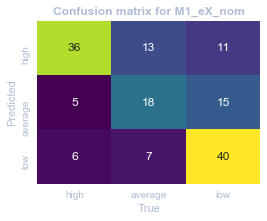

BUILDING MODEL FOR M2_A_nom

Accuracy on training sample: 90.55%
Accuracy on test sample: 68.87%


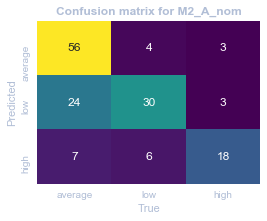

BUILDING MODEL FOR M3_C_nom

Accuracy on training sample: 89.67%
Accuracy on test sample: 72.19%


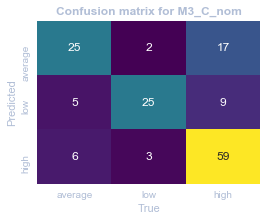

BUILDING MODEL FOR M4_E_nom

Accuracy on training sample: 89.15%
Accuracy on test sample: 68.21%


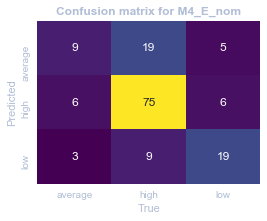

BUILDING MODEL FOR M5_O_nom

Accuracy on training sample: 86.64%
Accuracy on test sample: 60.93%


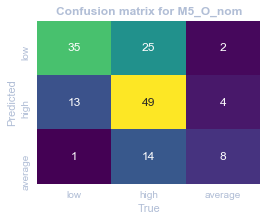

BUILDING MODEL FOR M6_H_nom

Accuracy on training sample: 84.72%
Accuracy on test sample: 68.21%


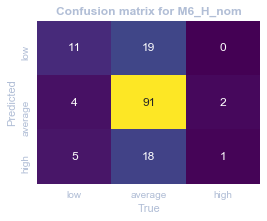

In [51]:
for trait in trait_names:
    trait = trait+'_nom'
    lm = RandomForestClassifier(n_estimators=500, max_features='log2', 
                                min_samples_leaf=20, oob_score = True)  
    lm = LogisticRegression()
#     lm = MultinomialNB()
#     lm = GradientBoostingClassifier() #seems best as yet
    build_model_nom(X_train=X_train, X_test=X_test, 
                y_train = train.loc[:,trait], y_test = test.loc[:,trait],
                vectorizer=None, model=lm)

In [ ]:
for trait in trait_names:
    lm = RandomForestRegressor(n_estimators=500, max_features='log2', 
                                min_samples_leaf=10, oob_score = True)  
#     lm = LinearRegression()
#     lm = GradientBoostingRegressor()
    build_model_cont(X_train=X_train, X_test=X_test, 
                y_train = train.loc[:,trait], y_test = test.loc[:,trait],
                vectorizer=None, model=lm)

## NN Models

In [109]:
n_features = X_train.shape[1]
batch_size = 512

nb_filter = 250
filter_length = 3
nb_epoch = 10

In [107]:
y_tr = train.loc[:,'M1_eX_nom']
y_te = test.loc[:,'M1_eX_nom']
labels = y_tr.unique()

le = LabelEncoder()
le.fit(labels)
y_train = np_utils.to_categorical(le.transform(y_tr), 3)
y_test = np_utils.to_categorical(le.transform(y_te), 3)
y_true = le.transform(y_te)
print(y_train)

[[ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 ..., 
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]


In [121]:
model = Sequential()
model.add(Dense(128, input_shape=(n_features,), activation = 'tanh'))
model.add(Dropout(0.3))
model.add(Dense(3, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size,  
          validation_split=0.05, verbose=2)

Train on 1287 samples, validate on 68 samples
Epoch 1/10
1s - loss: 1.3172 - acc: 0.3465 - val_loss: 1.0761 - val_acc: 0.3382
Epoch 2/10
0s - loss: 1.3047 - acc: 0.3341 - val_loss: 1.0734 - val_acc: 0.3676
Epoch 3/10
0s - loss: 1.2911 - acc: 0.3380 - val_loss: 1.0799 - val_acc: 0.3676
Epoch 4/10
0s - loss: 1.3316 - acc: 0.3271 - val_loss: 1.0940 - val_acc: 0.3676
Epoch 5/10
0s - loss: 1.2976 - acc: 0.3388 - val_loss: 1.0811 - val_acc: 0.3676
Epoch 6/10
0s - loss: 1.2866 - acc: 0.3481 - val_loss: 1.0781 - val_acc: 0.4559
Epoch 7/10
0s - loss: 1.3243 - acc: 0.3271 - val_loss: 1.0707 - val_acc: 0.4559
Epoch 8/10
0s - loss: 1.2769 - acc: 0.3551 - val_loss: 1.0707 - val_acc: 0.4706
Epoch 9/10
0s - loss: 1.2533 - acc: 0.3730 - val_loss: 1.0599 - val_acc: 0.5588
Epoch 10/10
0s - loss: 1.2634 - acc: 0.3512 - val_loss: 1.0643 - val_acc: 0.5000


In [122]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 128)               673408    
_________________________________________________________________
dropout_44 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 3)                 387       
Total params: 673,795
Trainable params: 673,795
Non-trainable params: 0
_________________________________________________________________


In [123]:
y_pred = model.predict_classes(X_test)
print(classification_report(y_true, y_pred))

 32/151 [=====>........................] - ETA: 1s

c:\users\mytas\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.00      0.00      0.00        38
          1       0.56      0.50      0.53        60
          2       0.39      0.72      0.51        53

avg / total       0.36      0.45      0.39       151



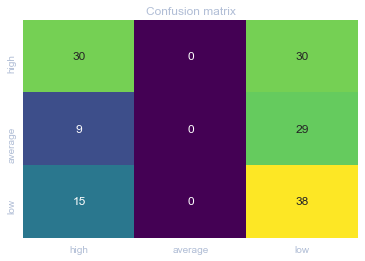

In [124]:
y_true_ = le.inverse_transform(y_true)
y_pred_ = le.inverse_transform(y_pred)
sns.heatmap(data=confusion_matrix(y_true_, y_pred_, labels = labels), 
            annot=True, fmt="d", cbar=False, 
            xticklabels=labels, yticklabels=labels, cmap='viridis')
plt.title("Confusion matrix")
plt.show()